# Baselines

1. Interaction with Rating
2. Interaction with Average Rating / Num of Friends / User Votes / Num of fans
3. Interaction with Review

* Datasets - Yelp
* Yelp - Restaurant / Cafe / Bar&Pub



In [ ]:
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 15.5 MB/s eta 0:00:00


In [ ]:
import nltk
import pandas as pd
import numpy as np
import contractions
import os, random, re, time
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.layers import Embedding, Input, Flatten, Multiply, Dense, Activation, Concatenate, Dropout, BatchNormalization, Conv1D, GlobalAveragePooling1D, MaxPooling1D, Add, Dot

pd.options.display.max_colwidth=20
pd.options.display.max_columns=999

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
def seed_everything(seed: int=42):
  random.seed(seed)
  np.random.seed(seed)
  os.environ['PYTHONASHSEED'] = str(seed)
  tf.random.set_seed(seed)

seed_everything(42)

In [ ]:
#rest = pd.read_csv('/content/drive/MyDrive/seminar/cdr_v2/yelp_rest_prepro.csv')
cafe = pd.read_csv('/content/drive/MyDrive/seminar/cdr_v2/yelp_cafe_prepro.csv')
bar = pd.read_csv('/content/drive/MyDrive/seminar/cdr_v2/yelp_bar_prepro.csv')

#print(rest.shape)
print(cafe.shape)
print(bar.shape)

(28117, 26)
(17735, 42)


## 1. Interaction with Rating
* MLP / GMF / NeuMF

In [ ]:
def rating_only(df=None):
  '''
  MLP, GMF, MLP 용 데이터셋 생성함수
  평점 정보만을 통해 평점 예측
  category 형으로 business_id, user_id 형변환
  '''

  cols = ['business_id', 'user_id', 'stars_y']
  df_baseline = df[cols]

  for col in ['business_id', 'user_id']:
    df_baseline[col] = df_baseline[col].astype('category')
    df_baseline[col] = df_baseline[col].cat.codes.values

  return df_baseline

rest_rating = rating_only(rest)
bar_rating = rating_only(bar)
cafe_rating = rating_only(cafe)

In [ ]:
# Bar, Cafe 데이터셋의 통계량 계산

rest_user_mean = rest_rating['stars_y'].mean()
rest_num_users = len(rest_rating['user_id'].unique()) + 1
rest_num_business = len(rest_rating['business_id'].unique()) + 1
print(f'bar_num_users : {rest_num_users} \t bar_num_business : {rest_num_business}')

bar_user_mean = bar_rating['stars_y'].mean()
bar_num_users = len(bar_rating['user_id'].unique()) + 1
bar_num_business = len(bar_rating['business_id'].unique()) + 1
print(f'bar_num_users : {bar_num_users} \t bar_num_business : {bar_num_business}')


cafe_user_mean = cafe_rating['stars_y'].mean()
cafe_num_users = len(cafe_rating['user_id'].unique()) + 1
cafe_num_business = len(cafe_rating['business_id'].unique()) + 1
print(f'cafe_num_users : {cafe_num_users} \t cafe_num_business : {cafe_num_business}')

bar_num_users : 87046 	 bar_num_business : 31717
bar_num_users : 3959 	 bar_num_business : 862
cafe_num_users : 5343 	 cafe_num_business : 2176


In [ ]:
def data_split(df=None, test_size=None):
  '''
  train/valid/test dataset split
  '''
  train, test = train_test_split(df, test_size=test_size, random_state=42)
  return train, test

rest_train, rest_test = data_split(rest_rating, 0.2)
rest_train, rest_valid = data_split(rest_train, 0.25)
print(rest_train.shape)
print(rest_valid.shape)
print(rest_test.shape)
print('\n\n')

bar_train, bar_test = data_split(bar_rating, 0.2)
bar_train, bar_valid = data_split(bar_train, 0.25)
print(bar_train.shape)
print(bar_valid.shape)
print(bar_test.shape)
print('\n\n')

cafe_train, cafe_test = data_split(cafe_rating, 0.2)
cafe_train, cafe_valid = data_split(cafe_train, 0.25)
print(cafe_train.shape)
print(cafe_valid.shape)
print(cafe_test.shape)

(642504, 3)
(214169, 3)
(214169, 3)



(10641, 3)
(3547, 3)
(3547, 3)



(16869, 3)
(5624, 3)
(5624, 3)


In [ ]:
def normalize(x):
  '''
  MLP / GMF / NCF - sigmoid 용 정규화 모델
  Min-Max Scaler 사용
  '''
  normalized_x = (((x-1) / (5-1)))
  return normalized_x

def de_normalize(x):
  '''
  normalize된 평점이 다시 원래 값을 갖도록 설정
  '''
  original_x = 4 * ((x - 0) / (1 - 0)) + 1
  return original_x

def rmse(y_true, y_pred):
  y_true = tf.cast(y_true, tf.float32)
  return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

rest_train['stars_y_scaled'] = rest_train['stars_y'].apply(lambda x: normalize(x))
rest_valid['stars_y_scaled'] = rest_valid['stars_y'].apply(lambda x: normalize(x))

bar_train['stars_y_scaled'] = bar_train['stars_y'].apply(lambda x: normalize(x))
bar_valid['stars_y_scaled'] = bar_valid['stars_y'].apply(lambda x: normalize(x))

cafe_train['stars_y_scaled'] = cafe_train['stars_y'].apply(lambda x: normalize(x))
cafe_valid['stars_y_scaled'] = cafe_valid['stars_y'].apply(lambda x: normalize(x))

In [ ]:
# 3) MLP
mlp_configs = {'latent_factor' : 32, 'drop_rate' : 0.2,
               'dense_1' : 64, 'dense_2' : 32, 'dense_3' : 16,
               'dense_4' : 8, 'output' : 1}

class MLP(tf.keras.Model):

  def __init__(self, num_users, num_business, **mlp_configs):
    super(MLP, self).__init__(name='MLP')

    user = Input(shape=(1, ), name='user_input', dtype='int32')
    business = Input(shape=(1, ), name='business_input', dtype='int32')
    user_emb = Embedding(num_users, mlp_configs['latent_factor'], input_length=user.shape[1],
                         embeddings_regularizer=l2(), name='user_emb')(user)
    bus_emb = Embedding(num_business, mlp_configs['latent_factor'], input_length=business.shape[1],
                        embeddings_regularizer=l2(), name='bus_emb')(business)

    concat = Concatenate(name='concat')([user_emb, bus_emb])
    drop = Dropout(mlp_configs['drop_rate'], name='dropout_1')(concat)

    mlp_1 = Dense(mlp_configs['dense_1'], activation='relu', name='mlp_1')(drop)
    drop_1 =   Dropout(mlp_configs['drop_rate'], name='dropout_2')(mlp_1)
    bn_1 = BatchNormalization(name='batch_norm_1')(drop_1)

    mlp_2 = Dense(mlp_configs['dense_2'], activation='relu', name='mlp_2')(bn_1)
    drop_2 = Dropout(mlp_configs['drop_rate'], name='dropout_3')(mlp_2)
    bn_2 = BatchNormalization(name='batch_norm_2')(drop_2)

    mlp_3 = Dense(mlp_configs['dense_3'], activation='relu', name='mlp_3')(bn_2)
    mlp_4 = Dense(mlp_configs['dense_4'], activation='relu', name='mlp_4')(mlp_3)
    output = Dense(mlp_configs['output'], activation='sigmoid', kernel_initializer='lecun_uniform', name='output')(mlp_4)

    self.model = Model(inputs=[user, business], outputs=output, name='MLP')
    self.model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy')

  def get_model(self):
    model = self.model
    return model

model_mlp_bar = MLP(bar_num_users, bar_num_business, **mlp_configs).get_model()
es = EarlyStopping(monitor='val_loss', mode = 'min', patience = 5, min_delta=0.001, restore_best_weights = True)
rp = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=2, min_delta=0.001)
print(model_mlp_bar.summary())

In [ ]:
# MLP - Bar Fitting
result = model_mlp_bar.fit(x=[bar_train['user_id'], bar_train['business_id']],
                   y=bar_train['stars_y_scaled'], epochs=100, batch_size=512,
                   validation_data=([bar_valid['user_id'], bar_valid['business_id']], bar_valid['stars_y_scaled']), callbacks=[es, rp])

Epoch 1/100
21/21 [==============================] - 3s 29ms/step - loss: 1.5834 - val_loss: 1.1250 - lr: 0.0010
Epoch 2/100
21/21 [==============================] - 0s 13ms/step - loss: 0.9604 - val_loss: 0.8360 - lr: 0.0010
Epoch 3/100
21/21 [==============================] - 0s 15ms/step - loss: 0.7318 - val_loss: 0.7417 - lr: 0.0010
Epoch 4/100
21/21 [==============================] - 0s 14ms/step - loss: 0.6300 - val_loss: 0.6909 - lr: 0.0010
Epoch 5/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5781 - val_loss: 0.6513 - lr: 0.0010
Epoch 6/100
21/21 [==============================] - 0s 15ms/step - loss: 0.5546 - val_loss: 0.6355 - lr: 0.0010
Epoch 7/100
21/21 [==============================] - 0s 14ms/step - loss: 0.5430 - val_loss: 0.6366 - lr: 0.0010
Epoch 8/100
21/21 [==============================] - 0s 17ms/step - loss: 0.5387 - val_loss: 0.6440 - lr: 0.0010
Epoch 9/100
21/21 [==============================] - 0s 17ms/step - loss: 0.5228 - val_loss: 0.6

In [ ]:
# MLP - Bar Prediction
pred_mlp = model_mlp_bar.predict([bar_test['user_id'], bar_test['business_id']])
pred_mlp = 4 *((pred_mlp - pred_mlp.min())/(pred_mlp.max() - pred_mlp.min())) + 1  # min-max scaler
rmse_temp = mean_squared_error(bar_test['stars_y'], pred_mlp.reshape(len(bar_test), -1), squared=False)
mae_temp = mean_absolute_error(bar_test['stars_y'], pred_mlp.reshape(len(bar_test), -1))
print(f'rmse : {rmse_temp}')
print(f'mae : {mae_temp}')

111/111 [==============================] - 1s 2ms/step
rmse : 1.396113254358892
mae : 1.1694719713104589


In [ ]:
# MLP - Cafe Fitting
model_mlp_cafe = MLP(cafe_num_users, cafe_num_business, **mlp_configs).get_model()
result = model_mlp_cafe.fit(x=[cafe_train['user_id'], cafe_train['business_id']],
                   y=cafe_train['stars_y_scaled'], epochs=100, batch_size=512,
                   validation_data=([cafe_valid['user_id'], cafe_valid['business_id']], cafe_valid['stars_y_scaled']), callbacks=[es, rp])

Epoch 1/100
33/33 [==============================] - 4s 29ms/step - loss: 1.5959 - val_loss: 1.0033 - lr: 0.0010
Epoch 2/100
33/33 [==============================] - 0s 15ms/step - loss: 0.7397 - val_loss: 0.7455 - lr: 0.0010
Epoch 3/100
33/33 [==============================] - 1s 15ms/step - loss: 0.6088 - val_loss: 0.7126 - lr: 0.0010
Epoch 4/100
33/33 [==============================] - 0s 13ms/step - loss: 0.5754 - val_loss: 0.6974 - lr: 0.0010
Epoch 5/100
33/33 [==============================] - 0s 13ms/step - loss: 0.5615 - val_loss: 0.6778 - lr: 0.0010
Epoch 6/100
33/33 [==============================] - 0s 13ms/step - loss: 0.5515 - val_loss: 0.6632 - lr: 0.0010
Epoch 7/100
33/33 [==============================] - 0s 14ms/step - loss: 0.5423 - val_loss: 0.6493 - lr: 0.0010
Epoch 8/100
33/33 [==============================] - 0s 12ms/step - loss: 0.5389 - val_loss: 0.6281 - lr: 0.0010
Epoch 9/100
33/33 [==============================] - 0s 12ms/step - loss: 0.5351 - val_loss: 0.6

In [ ]:
# MLP - Cafe Prediction
pred_mlp = model_mlp_cafe.predict([cafe_test['user_id'], cafe_test['business_id']])
pred_mlp = 4 *((pred_mlp - pred_mlp.min())/(pred_mlp.max() - pred_mlp.min())) + 1  # min-max scaler
rmse_temp = mean_squared_error(cafe_test['stars_y'], pred_mlp.reshape(len(cafe_test), -1), squared=False)
mae_temp = mean_absolute_error(cafe_test['stars_y'], pred_mlp.reshape(len(cafe_test), -1))
print(f'rmse : {rmse_temp}')
print(f'mae : {mae_temp}')

176/176 [==============================] - 1s 3ms/step
rmse : 1.0336464571639055
mae : 0.8075741952547477


In [ ]:
# MLP - Restaurant Fitting
model_mlp_rest = MLP(rest_num_users, rest_num_business, **mlp_configs).get_model()
result = model_mlp_rest.fit(x=[rest_train['user_id'], rest_train['business_id']],
                   y=rest_train['stars_y_scaled'], epochs=100, batch_size=512,
                   validation_data=([rest_valid['user_id'], rest_valid['business_id']], rest_valid['stars_y_scaled']), callbacks=[es, rp])

Epoch 1/100
1255/1255 [==============================] - 13s 8ms/step - loss: 1.1594 - val_loss: 0.8052 - lr: 0.0010
Epoch 2/100
1255/1255 [==============================] - 11s 9ms/step - loss: 0.8014 - val_loss: 0.8114 - lr: 0.0010
Epoch 3/100
1255/1255 [==============================] - 11s 9ms/step - loss: 0.7948 - val_loss: 0.7916 - lr: 0.0010
Epoch 4/100
1255/1255 [==============================] - 10s 8ms/step - loss: 0.8052 - val_loss: 0.7969 - lr: 0.0010
Epoch 5/100
1255/1255 [==============================] - 10s 8ms/step - loss: 0.8068 - val_loss: 0.8150 - lr: 0.0010
Epoch 6/100
1255/1255 [==============================] - 10s 8ms/step - loss: 0.6546 - val_loss: 0.6261 - lr: 1.0000e-04
Epoch 7/100
1255/1255 [==============================] - 10s 8ms/step - loss: 0.6178 - val_loss: 0.6208 - lr: 1.0000e-04
Epoch 8/100
1255/1255 [==============================] - 11s 9ms/step - loss: 0.6125 - val_loss: 0.6196 - lr: 1.0000e-04
Epoch 9/100
1255/1255 [=============================

In [ ]:
# MLP - Rest Prediction
pred_mlp = model_mlp_rest.predict([rest_test['user_id'], rest_test['business_id']])
pred_mlp = 4 *((pred_mlp - pred_mlp.min())/(pred_mlp.max() - pred_mlp.min())) + 1  # min-max scaler
rmse_temp = mean_squared_error(rest_test['stars_y'], pred_mlp.reshape(len(rest_test), -1), squared=False)
mae_temp = mean_absolute_error(rest_test['stars_y'], pred_mlp.reshape(len(rest_test), -1))
print(f'rmse : {rmse_temp}')
print(f'mae : {mae_temp}')

6693/6693 [==============================] - 20s 3ms/step
rmse : 1.1451033261267662
mae : 0.8854291449003074


In [ ]:
# 4) GMF
gmf_configs = {'latent_factor' : 32,
               'output' : 1}

class GMF(tf.keras.Model):

  def __init__(self, num_users, num_business, **gmf_configs):
    super(GMF, self).__init__(name='GMF')

    user = Input(shape=(1, ), name='user_input', dtype='int64')
    business = Input(shape=(1, ), name='business_input', dtype='int64')

    user_emb = Embedding(num_users, gmf_configs['latent_factor'], input_length=user.shape[1], embeddings_regularizer=l2(), name='user_embedding')(user)
    bus_emb = Embedding(num_business, gmf_configs['latent_factor'], input_length=business.shape[1], embeddings_regularizer=l2(), name='business_embedding')(business)
    user_emb = Flatten(name='user_embedding_flat')(user_emb)
    bus_emb = Flatten(name='business_embedding_flat')(bus_emb)

    concat = Multiply()([user_emb, bus_emb])
    output = Dense(gmf_configs['output'], activation='sigmoid', kernel_initializer='lecun_uniform', name='output_layer')(concat)

    self.model = Model(inputs=[user, business], outputs=output, name='GMF')
    self.model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy')

  def get_model(self):
    model = self.model
    return model

model_gmf_bar = GMF(bar_num_users, bar_num_business, **gmf_configs).get_model()
print(model_gmf_bar.summary())

Model: "GMF"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 business_input (InputLayer)    [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 32)        126688      ['user_input[0][0]']             
                                                                                                  
 business_embedding (Embedding)  (None, 1, 32)       27584       ['business_input[0][0]']         
                                                                                                

In [ ]:
# GMF - Bar Fitting
result_2 = model_gmf_bar.fit(x=[bar_train['user_id'], bar_train['business_id']],
                   y=bar_train['stars_y_scaled'], epochs=100, batch_size=512,
                   validation_data=([bar_valid['user_id'], bar_valid['business_id']], bar_valid['stars_y_scaled']), callbacks=[es, rp])

Epoch 1/100
21/21 [==============================] - 1s 15ms/step - loss: 1.4094 - val_loss: 0.9684 - lr: 0.0010
Epoch 2/100
21/21 [==============================] - 0s 7ms/step - loss: 0.8146 - val_loss: 0.7158 - lr: 0.0010
Epoch 3/100
21/21 [==============================] - 0s 6ms/step - loss: 0.6927 - val_loss: 0.6794 - lr: 0.0010
Epoch 4/100
21/21 [==============================] - 0s 6ms/step - loss: 0.6761 - val_loss: 0.6729 - lr: 0.0010
Epoch 5/100
21/21 [==============================] - 0s 7ms/step - loss: 0.6708 - val_loss: 0.6680 - lr: 0.0010
Epoch 6/100
21/21 [==============================] - 0s 7ms/step - loss: 0.6661 - val_loss: 0.6634 - lr: 0.0010
Epoch 7/100
21/21 [==============================] - 0s 6ms/step - loss: 0.6616 - val_loss: 0.6589 - lr: 0.0010
Epoch 8/100
21/21 [==============================] - 0s 7ms/step - loss: 0.6573 - val_loss: 0.6547 - lr: 0.0010
Epoch 9/100
21/21 [==============================] - 0s 6ms/step - loss: 0.6531 - val_loss: 0.6505 - lr

In [ ]:
# GMF - Bar Prediction

pred_gmf = model_gmf_bar.predict([bar_test['user_id'], bar_test['business_id']], batch_size=32)
pred_gmf = 4 *((pred_gmf - pred_gmf.min()+ 0.00001)/(pred_gmf.max() - pred_gmf.min()+ 0.00001)) + 1  # min-max scaler
rmse_temp = mean_squared_error(bar_test['stars_y'], pred_gmf, squared=False)
mae_temp = mean_absolute_error(bar_test['stars_y'], pred_gmf)
print(f'rmse : {rmse_temp}')
print(f'mae : {mae_temp}')

111/111 [==============================] - 0s 1ms/step
rmse : 1.3897810623202849
mae : 0.979137299126022


In [ ]:
# GMF - Cafe Fitting
model_gmf_cafe = GMF(cafe_num_users, cafe_num_business, **gmf_configs).get_model()

result_2 = model_gmf_cafe.fit(x=[cafe_train['user_id'], cafe_train['business_id']],
                   y=cafe_train['stars_y_scaled'], epochs=100, batch_size=512,
                   validation_data=([cafe_valid['user_id'], cafe_valid['business_id']], cafe_valid['stars_y_scaled']), callbacks=[es, rp])

Epoch 1/100
33/33 [==============================] - 1s 12ms/step - loss: 1.4995 - val_loss: 0.8251 - lr: 0.0010
Epoch 2/100
33/33 [==============================] - 0s 6ms/step - loss: 0.7187 - val_loss: 0.6781 - lr: 0.0010
Epoch 3/100
33/33 [==============================] - 0s 6ms/step - loss: 0.6727 - val_loss: 0.6685 - lr: 0.0010
Epoch 4/100
33/33 [==============================] - 0s 7ms/step - loss: 0.6645 - val_loss: 0.6608 - lr: 0.0010
Epoch 5/100
33/33 [==============================] - 0s 8ms/step - loss: 0.6571 - val_loss: 0.6537 - lr: 0.0010
Epoch 6/100
33/33 [==============================] - 0s 6ms/step - loss: 0.6501 - val_loss: 0.6470 - lr: 0.0010
Epoch 7/100
33/33 [==============================] - 0s 7ms/step - loss: 0.6434 - val_loss: 0.6405 - lr: 0.0010
Epoch 8/100
33/33 [==============================] - 0s 7ms/step - loss: 0.6371 - val_loss: 0.6344 - lr: 0.0010
Epoch 9/100
33/33 [==============================] - 0s 7ms/step - loss: 0.6311 - val_loss: 0.6286 - lr

In [ ]:
# GMF - Cafe Prediction
pred_gmf = model_gmf_cafe.predict([cafe_test['user_id'], cafe_test['business_id']])

pred_gmf = 4 *((pred_gmf - pred_gmf.min()+0.00001)/(pred_gmf.max() - pred_gmf.min()+0.00001)) + 1  # min-max scaler
rmse_temp = mean_squared_error(cafe_test['stars_y'], pred_gmf, squared=False)
mae_temp = mean_absolute_error(cafe_test['stars_y'], pred_gmf)
print(f'rmse : {rmse_temp}')
print(f'mae : {mae_temp}')

176/176 [==============================] - 0s 2ms/step
rmse : 1.4093646359612373
mae : 0.923719772403983


In [ ]:
# GMF - Restaurant Fitting
model_gmf_rest = GMF(rest_num_users, rest_num_business, **gmf_configs).get_model()

result_2 = model_gmf_rest.fit(x=[rest_train['user_id'], rest_train['business_id']],
                   y=rest_train['stars_y_scaled'], epochs=100, batch_size=512,
                   validation_data=([rest_valid['user_id'], rest_valid['business_id']], rest_valid['stars_y_scaled']), callbacks=[es, rp])

Epoch 1/100
1255/1255 [==============================] - 6s 4ms/step - loss: 0.9869 - val_loss: 0.6143 - lr: 0.0010
Epoch 2/100
1255/1255 [==============================] - 6s 5ms/step - loss: 0.6134 - val_loss: 0.6136 - lr: 0.0010
Epoch 3/100
1255/1255 [==============================] - 5s 4ms/step - loss: 0.6133 - val_loss: 0.6136 - lr: 0.0010
Epoch 4/100
1255/1255 [==============================] - 5s 4ms/step - loss: 0.6133 - val_loss: 0.6136 - lr: 1.0000e-04
Epoch 5/100
1255/1255 [==============================] - 5s 4ms/step - loss: 0.6133 - val_loss: 0.6136 - lr: 1.0000e-04
Epoch 6/100
1255/1255 [==============================] - 5s 4ms/step - loss: 0.6133 - val_loss: 0.6136 - lr: 1.0000e-05


In [ ]:
# GMF - Rest Prediction
pred_gmf = model_gmf_rest.predict([rest_test['user_id'], rest_test['business_id']])

pred_gmf = 4 *((pred_gmf - pred_gmf.min()+0.00001)/(pred_gmf.max() - pred_gmf.min()+0.00001)) + 1  # min-max scaler
rmse_temp = mean_squared_error(rest_test['stars_y'], pred_gmf, squared=False)
mae_temp = mean_absolute_error(rest_test['stars_y'], pred_gmf)
print(f'rmse : {rmse_temp}')
print(f'mae : {mae_temp}')

6693/6693 [==============================] - 9s 1ms/step
rmse : 1.7474239519384336
mae : 1.20991833552008


In [ ]:
# 5) NeuMF
# NCF
ncf_configs = {'latent_factor' : 32, 'embed_dim' : 32, 'drop_rate' : 0.2,
               'dense_1' : 64, 'dense_2' : 32, 'dense_3' : 16,
               'dense_4' : 8, 'output' : 1}

class NeuMF(tf.keras.Model):

  def __init__(self, num_users, num_business, **ncf_configs):
    super(NeuMF, self).__init__(name='NeuMF')


    user = Input(shape=(1, ), name='user_input', dtype='int32')
    business = Input(shape=(1, ), name='business_input', dtype='int32')

    gmf_user_emb= Embedding(num_users, ncf_configs['latent_factor'], input_length=user.shape[1],
                            embeddings_regularizer=l2(), name='gmf_user_emb')(user)
    gmf_bus_emb = Embedding(num_business, ncf_configs['latent_factor'], input_length=business.shape[1],
                            embeddings_regularizer=l2(),name='gmf_business_emb')(business)

    mlp_user_emb = Embedding(num_users, ncf_configs['embed_dim'], input_length=user.shape[1],
                             embeddings_regularizer=l2(),name='mlp_user_emb')(user)
    mlp_bus_emb = Embedding(num_business, ncf_configs['embed_dim'], input_length=business.shape[1],
                            embeddings_regularizer=l2(),name='mlp_business_emb')(business)

    gmf_user_emb = Flatten(name='gmf_user_flat')(gmf_user_emb)
    gmf_bus_emb = Flatten(name='gmf_business_flat')(gmf_bus_emb)
    mlp_user_emb = Flatten(name='mlp_user_flat')(mlp_user_emb)
    mlp_bus_emb = Flatten(name='mlp_business_flat')(mlp_bus_emb)

    gmf_mul = Multiply(name='gmf_mul')([gmf_user_emb, gmf_bus_emb])
    mlp_concat = Concatenate(name='mlp_concat')([mlp_user_emb, mlp_bus_emb])
    mlp_dropout = Dropout(ncf_configs['drop_rate'], name='dropout_1')(mlp_concat)

    mlp_layer_1 = Dense(ncf_configs['dense_1'], activation='relu', name='mlp_1')(mlp_dropout)
    mlp_dropout_1 = Dropout(ncf_configs['drop_rate'], name='dropout_2')(mlp_layer_1)
    mlp_bn_1 = BatchNormalization(name='bn_1')(mlp_dropout_1)

    mlp_layer_2 = Dense(ncf_configs['dense_2'], activation='relu', name='mlp_2')(mlp_bn_1)
    mlp_dropout_2 = Dropout(ncf_configs['drop_rate'], name='dropout_3')(mlp_layer_2)
    mlp_bn_2 = BatchNormalization(name='bn_2')(mlp_dropout_2)

    mlp_layer_3 = Dense(ncf_configs['dense_3'], activation='relu', name='mlp_3')(mlp_bn_2)
    mlp_layer_4 = Dense(ncf_configs['dense_4'], activation='relu', name='mlp_4')(mlp_layer_3)

    merge_vector = tf.keras.layers.concatenate([gmf_mul, mlp_layer_4])
    output_layer = Dense(ncf_configs['output'], activation='sigmoid', kernel_initializer='lecun_uniform', name='output_layer')(merge_vector)

    self.model = Model([user, business], output_layer, name='NeuMF')
    self.model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy')

  def get_model(self):
    model = self.model
    return model

model_ncf_bar = NeuMF(bar_num_users, bar_num_business, **ncf_configs).get_model()
print(model_ncf_bar.summary())

Model: "NeuMF"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 business_input (InputLayer)    [(None, 1)]          0           []                               
                                                                                                  
 mlp_user_emb (Embedding)       (None, 1, 32)        126688      ['user_input[0][0]']             
                                                                                                  
 mlp_business_emb (Embedding)   (None, 1, 32)        27584       ['business_input[0][0]']         
                                                                                              

In [ ]:
# NCF - Bar Fitting
result = model_ncf_bar.fit(x=[bar_train['user_id'], bar_train['business_id']],
                   y=bar_train['stars_y_scaled'], epochs=100, batch_size=512,
                   validation_data=([bar_valid['user_id'], bar_valid['business_id']], bar_valid['stars_y_scaled']), callbacks=[es, rp])

Epoch 1/100
21/21 [==============================] - 3s 27ms/step - loss: 2.1044 - val_loss: 1.3115 - lr: 0.0010
Epoch 2/100
21/21 [==============================] - 0s 12ms/step - loss: 0.9096 - val_loss: 0.7868 - lr: 0.0010
Epoch 3/100
21/21 [==============================] - 0s 12ms/step - loss: 0.6320 - val_loss: 0.6909 - lr: 0.0010
Epoch 4/100
21/21 [==============================] - 0s 12ms/step - loss: 0.5778 - val_loss: 0.6798 - lr: 0.0010
Epoch 5/100
21/21 [==============================] - 0s 12ms/step - loss: 0.5541 - val_loss: 0.6822 - lr: 0.0010
Epoch 6/100
21/21 [==============================] - 0s 13ms/step - loss: 0.5410 - val_loss: 0.6777 - lr: 0.0010
Epoch 7/100
21/21 [==============================] - 0s 13ms/step - loss: 0.5338 - val_loss: 0.6675 - lr: 0.0010
Epoch 8/100
21/21 [==============================] - 0s 12ms/step - loss: 0.5262 - val_loss: 0.6595 - lr: 0.0010
Epoch 9/100
21/21 [==============================] - 0s 13ms/step - loss: 0.5251 - val_loss: 0.6

In [ ]:
# NCF - Bar Prediction
pred_ncf = model_ncf_bar.predict([bar_test['user_id'], bar_test['business_id']])
pred_ncf = 4 *((pred_ncf - pred_ncf.min())/(pred_ncf.max() - pred_ncf.min())) + 1  # min-max scaler
rmse_temp = mean_squared_error(bar_test['stars_y'], pred_ncf, squared=False)
mae_temp = mean_absolute_error(bar_test['stars_y'], pred_ncf)
print(f'rmse : {rmse_temp}')
print(f'mae : {mae_temp}')

111/111 [==============================] - 0s 2ms/step
rmse : 1.084958093307082
mae : 0.8854545940975085


In [ ]:
# NCF - Cafe Fitting
model_ncf_cafe = NeuMF(cafe_num_users, cafe_num_business, **ncf_configs).get_model()
result_2 = model_ncf_cafe.fit(x=[cafe_train['user_id'], cafe_train['business_id']],
                   y=cafe_train['stars_y_scaled'], epochs=100, batch_size=512,
                   validation_data=([cafe_valid['user_id'], cafe_valid['business_id']], cafe_valid['stars_y_scaled']), callbacks=[es, rp])

Epoch 1/100
33/33 [==============================] - 4s 22ms/step - loss: 2.2852 - val_loss: 1.0268 - lr: 0.0010
Epoch 2/100
33/33 [==============================] - 0s 13ms/step - loss: 0.6881 - val_loss: 0.6897 - lr: 0.0010
Epoch 3/100
33/33 [==============================] - 0s 14ms/step - loss: 0.5685 - val_loss: 0.6802 - lr: 0.0010
Epoch 4/100
33/33 [==============================] - 0s 13ms/step - loss: 0.5497 - val_loss: 0.6806 - lr: 0.0010
Epoch 5/100
33/33 [==============================] - 0s 14ms/step - loss: 0.5422 - val_loss: 0.6705 - lr: 0.0010
Epoch 6/100
33/33 [==============================] - 0s 14ms/step - loss: 0.5346 - val_loss: 0.6510 - lr: 0.0010
Epoch 7/100
33/33 [==============================] - 0s 14ms/step - loss: 0.5292 - val_loss: 0.6429 - lr: 0.0010
Epoch 8/100
33/33 [==============================] - 0s 15ms/step - loss: 0.5267 - val_loss: 0.6370 - lr: 0.0010
Epoch 9/100
33/33 [==============================] - 0s 15ms/step - loss: 0.5252 - val_loss: 0.6

In [ ]:
# NCF - Cafe Prediction
pred_ncf = model_ncf_cafe.predict([cafe_test['user_id'], cafe_test['business_id']])
pred_ncf = 4 *((pred_ncf - pred_ncf.min())/(pred_ncf.max() - pred_ncf.min())) + 1  # min-max scaler
rmse_temp = mean_squared_error(cafe_test['stars_y'], pred_ncf, squared=False)
mae_temp = mean_absolute_error(cafe_test['stars_y'], pred_ncf)
print(f'rmse : {rmse_temp}')
print(f'mae : {mae_temp}')

176/176 [==============================] - 1s 2ms/step
rmse : 1.071385340119477
mae : 0.8519778063846686


In [ ]:
# NCF - Rest Fitting
model_ncf_rest = NeuMF(rest_num_users, rest_num_business, **ncf_configs).get_model()
result_2 = model_ncf_rest.fit(x=[rest_train['user_id'], rest_train['business_id']],
                   y=rest_train['stars_y_scaled'], epochs=100, batch_size=512,
                   validation_data=([rest_valid['user_id'], rest_valid['business_id']], rest_valid['stars_y_scaled']), callbacks=[es, rp])

Epoch 1/100
1255/1255 [==============================] - 12s 7ms/step - loss: 1.4935 - val_loss: 0.8145 - lr: 0.0010
Epoch 2/100
1255/1255 [==============================] - 9s 7ms/step - loss: 0.7996 - val_loss: 0.7941 - lr: 0.0010
Epoch 3/100
1255/1255 [==============================] - 8s 6ms/step - loss: 0.8104 - val_loss: 0.8151 - lr: 0.0010
Epoch 4/100
1255/1255 [==============================] - 8s 7ms/step - loss: 0.8218 - val_loss: 0.8150 - lr: 0.0010
Epoch 5/100
1255/1255 [==============================] - 8s 7ms/step - loss: 0.6544 - val_loss: 0.6263 - lr: 1.0000e-04
Epoch 6/100
1255/1255 [==============================] - 8s 6ms/step - loss: 0.6191 - val_loss: 0.6208 - lr: 1.0000e-04
Epoch 7/100
1255/1255 [==============================] - 8s 7ms/step - loss: 0.6135 - val_loss: 0.6203 - lr: 1.0000e-04
Epoch 8/100
1255/1255 [==============================] - 8s 6ms/step - loss: 0.6117 - val_loss: 0.6203 - lr: 1.0000e-04
Epoch 9/100
1255/1255 [==============================] 

In [ ]:
# NCF - Rest Prediction
pred_ncf = model_ncf_rest.predict([rest_test['user_id'], rest_test['business_id']])
pred_ncf = 4 *((pred_ncf - pred_ncf.min())/(pred_ncf.max() - pred_ncf.min())) + 1  # min-max scaler
rmse_temp = mean_squared_error(rest_test['stars_y'], pred_ncf, squared=False)
mae_temp = mean_absolute_error(rest_test['stars_y'], pred_ncf)
print(f'rmse : {rmse_temp}')
print(f'mae : {mae_temp}')

6693/6693 [==============================] - 11s 2ms/step
rmse : 1.1467682248047475
mae : 0.8965349421541392


## 2. Interaction with Average Rating / Num of Friends / User Votes / Num of fans
* DNNRec 모델에 Average Rating / Num of Friends / User Votes / Num of Fans 입력값으로 넣어 Rating 예측


In [ ]:
def friends(x):
  '''
  num_friends - 친구의 수로 표현
  '''
  friends = len(x.split(','))

  return friends

bar['num_friends'] = bar['friends'].apply(lambda x: friends(x))
cafe['num_friends'] = cafe['friends'].apply(lambda x: friends(x))

In [ ]:
def dnnrec_dataset(df=None):
  '''
  MLP, GMF, MLP 용 데이터셋 생성함수
  평점 정보만을 통해 평점 예측
  category 형으로 business_id, user_id 형변환
  '''

  cols = ['business_id', 'user_id', 'stars_y', 'num_friends', 'user_votes', 'fans', 'average_stars', 'stars_x']
  df_baseline = df[cols]

  for col in ['business_id', 'user_id']:
    df_baseline[col] = df_baseline[col].astype('category')
    df_baseline[col] = df_baseline[col].cat.codes.values

  return df_baseline

bar_dnn = dnnrec_dataset(bar)
cafe_dnn = dnnrec_dataset(cafe)

<ipython-input-20-16970b28835e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_baseline[col] = df_baseline[col].astype('category')
<ipython-input-20-16970b28835e>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_baseline[col] = df_baseline[col].cat.codes.values
<ipython-input-20-16970b28835e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

In [ ]:
bar_dnn.head()

,business_id,user_id,stars_y,num_friends,user_votes,fans,average_stars,stars_x
0,138,3099,3,53,346,8,3.50,2.5
1,166,3302,4,335,2040,45,4.14,3.5
2,204,3302,4,335,2040,45,4.14,3.0
3,65,3302,5,335,2040,45,4.14,4.5
4,580,3302,4,335,2040,45,4.14,3.5


In [ ]:
def data_split(df=None, test_size=None):
  '''
  train/valid/test dataset split
  '''
  train, test = train_test_split(df, test_size=test_size, random_state=42)
  return train, test

bar_train, bar_test = data_split(bar_dnn, 0.2)
bar_train, bar_valid = data_split(bar_train, 0.25)
print(bar_train.shape)
print(bar_valid.shape)
print(bar_test.shape)
print('\n\n')

cafe_train, cafe_test = data_split(cafe_dnn, 0.2)
cafe_train, cafe_valid = data_split(cafe_train, 0.25)
print(cafe_train.shape)
print(cafe_valid.shape)
print(cafe_test.shape)

(10641, 8)
(3547, 8)
(3547, 8)



(16869, 8)
(5624, 8)
(5624, 8)


In [ ]:
def normalize(x):
  '''
  MLP / GMF / NCF - sigmoid 용 정규화 모델
  Min-Max Scaler 사용
  '''
  normalized_x = (((x-1) / (5-1)))
  return normalized_x

def de_normalize(x):
  '''
  normalize된 평점이 다시 원래 값을 갖도록 설정
  '''
  original_x = 4 * ((x - 0) / (1 - 0)) + 1
  return original_x

def rmse(y_true, y_pred):
  y_true = tf.cast(y_true, tf.float32)
  return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

bar_train['stars_y_scaled'] = bar_train['stars_y'].apply(lambda x: normalize(x))
bar_valid['stars_y_scaled'] = bar_valid['stars_y'].apply(lambda x: normalize(x))

cafe_train['stars_y_scaled'] = cafe_train['stars_y'].apply(lambda x: normalize(x))
cafe_valid['stars_y_scaled'] = cafe_valid['stars_y'].apply(lambda x: normalize(x))

In [ ]:
# 4) DNNRec
dnn_configs = {'latent_factor' : 32, 'drop_rate' : 0.2,
               'dense_1' : 64, 'dense_2' : 32, 'dense_3' : 16,
               'dense_4' : 8, 'output' : 1}

class DNNRec(tf.keras.Model):

  def __init__(self, num_users, num_business, **dnn_configs):
    super(DNNRec, self).__init__(name='DNNRec')

    user = Input(shape=(1, ), name='user_input', dtype='int32')
    business = Input(shape=(1, ), name='business_input', dtype='int32')
    friends = Input(shape=(1, ), name='num_friends', dtype='int32')
    user_votes = Input(shape=(1, ), name='user_votes', dtype='int32')
    fans = Input(shape=(1, ), name='num_fans', dtype='int32')
    user_rating_avg = Input(shape=(1, ), name='user_avg_rating', dtype='float32')
    business_rating_avg = Input(shape=(1, ), name='item_avg_rating', dtype='float32')

    user_emb = Embedding(num_users, dnn_configs['latent_factor'], input_length=user.shape[1],
                         embeddings_regularizer=l2(), name='user_emb')(user)
    bus_emb = Embedding(num_business, dnn_configs['latent_factor'], input_length=business.shape[1],
                        embeddings_regularizer=l2(), name='bus_emb')(business)
    user_emb_flat = Flatten(name='user_emb_flat')(user_emb)
    bus_emb_flat = Flatten(name='item_emb_flat')(bus_emb)
    friends_emb = Dense(10, activation=tf.keras.layers.LeakyReLU(alpha=0.01), kernel_regularizer='l2', name='num_friends_emb')(friends)
    user_votes_emb = Dense(10, activation=tf.keras.layers.LeakyReLU(alpha=0.01), kernel_regularizer='l2', name='user_votes_emb')(user_votes)
    fans_emb = Dense(10, activation=tf.keras.layers.LeakyReLU(alpha=0.01), kernel_regularizer='l2', name='num_fans_emb')(fans)
    user_rating_avg_emb = Dense(10, activation=tf.keras.layers.LeakyReLU(alpha=0.01), kernel_regularizer='l2', name='user_avg_rating_emb')(user_rating_avg)
    business_rating_avg_emb = Dense(10, activation=tf.keras.layers.LeakyReLU(alpha=0.01), kernel_regularizer='l2', name='item_avg_rating_emb')(business_rating_avg)

    ui_concat = Concatenate(name='id_concat')([user_emb_flat, bus_emb_flat])
    drop = Dropout(dnn_configs['drop_rate'], name='dropout_1')(ui_concat)
    side_concat = Concatenate(name='side_concat')([friends_emb, user_votes_emb, fans_emb, user_rating_avg_emb, business_rating_avg_emb])
    concat = Concatenate(name='total_concat')([ui_concat, side_concat])

    mlp_1 = Dense(dnn_configs['dense_1'], activation=tf.keras.layers.LeakyReLU(alpha=0.01), name='mlp_1')(drop)
    drop_1 = Dropout(dnn_configs['drop_rate'], name='dropout_2')(mlp_1)
    bn_1 = BatchNormalization(name='batch_norm_1')(drop_1)

    mlp_2 = Dense(dnn_configs['dense_2'], activation=tf.keras.layers.LeakyReLU(alpha=0.01), name='mlp_2')(bn_1)
    drop_2 = Dropout(dnn_configs['drop_rate'], name='dropout_3')(mlp_2)
    bn_2 = BatchNormalization(name='batch_norm_2')(drop_2)

    mlp_3 = Dense(dnn_configs['dense_3'], activation=tf.keras.layers.LeakyReLU(alpha=0.01), name='mlp_3')(bn_2)
    mlp_4 = Dense(dnn_configs['dense_4'], activation=tf.keras.layers.LeakyReLU(alpha=0.01), name='mlp_4')(mlp_3)
    output = Dense(dnn_configs['output'], activation='sigmoid', kernel_initializer='lecun_uniform', name='output')(mlp_4)

    self.model = Model(inputs=[user, business, friends, user_votes, fans, user_rating_avg, business_rating_avg], outputs=output, name='DNNRec')
    self.model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy')

  def get_model(self):
    model = self.model
    return model

dnnrec_bar = DNNRec(bar_num_users, bar_num_business, **dnn_configs).get_model()
es = EarlyStopping(monitor='val_loss', mode = 'min', patience = 5, min_delta=0.001, restore_best_weights = True)
rp = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=2, min_delta=0.001)
print(dnnrec_bar.summary())

Model: "DNNRec"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 business_input (InputLayer)    [(None, 1)]          0           []                               
                                                                                                  
 user_emb (Embedding)           (None, 1, 32)        126688      ['user_input[0][0]']             
                                                                                                  
 bus_emb (Embedding)            (None, 1, 32)        27584       ['business_input[0][0]']         
                                                                                             

In [ ]:
# DNNRec - Bar Fitting
result = dnnrec_bar.fit(x=[bar_train['user_id'], bar_train['business_id'], bar_train['num_friends'], bar_train['user_votes'], bar_train['fans'],
                  bar_train['average_stars'], bar_train['stars_x']],
               y=bar_train['stars_y_scaled'], epochs=100, batch_size=512,
               validation_data = ([bar_valid['user_id'], bar_valid['business_id'], bar_valid['num_friends'], bar_valid['user_votes'], bar_valid['fans'],
                                   bar_valid['average_stars'], bar_valid['stars_x']],
                                  bar_valid['stars_y_scaled']), callbacks=[es, rp]
               )

Epoch 1/100
21/21 [==============================] - 2s 22ms/step - loss: 1.4329 - val_loss: 1.0852 - lr: 0.0010
Epoch 2/100
21/21 [==============================] - 0s 11ms/step - loss: 0.8409 - val_loss: 0.7968 - lr: 0.0010
Epoch 3/100
21/21 [==============================] - 0s 10ms/step - loss: 0.6606 - val_loss: 0.7053 - lr: 0.0010
Epoch 4/100
21/21 [==============================] - 0s 11ms/step - loss: 0.5982 - val_loss: 0.6716 - lr: 0.0010
Epoch 5/100
21/21 [==============================] - 0s 10ms/step - loss: 0.5687 - val_loss: 0.6543 - lr: 0.0010
Epoch 6/100
21/21 [==============================] - 0s 12ms/step - loss: 0.5548 - val_loss: 0.6448 - lr: 0.0010
Epoch 7/100
21/21 [==============================] - 0s 12ms/step - loss: 0.5422 - val_loss: 0.6325 - lr: 0.0010
Epoch 8/100
21/21 [==============================] - 0s 10ms/step - loss: 0.5352 - val_loss: 0.6272 - lr: 0.0010
Epoch 9/100
21/21 [==============================] - 0s 12ms/step - loss: 0.5313 - val_loss: 0.6

In [ ]:
# DNNRec - Bar Prediction
pred_dnnrec = dnnrec_bar.predict([bar_test['user_id'], bar_test['business_id'], bar_test['num_friends'], bar_test['user_votes'], bar_test['fans'], bar_test['average_stars'], bar_test['stars_x']])
pred_dnnrec = 4 *((pred_dnnrec - pred_dnnrec.min())/(pred_dnnrec.max() - pred_dnnrec.min())) + 1  # min-max scaler
rmse_temp = mean_squared_error(bar_test['stars_y'], pred_dnnrec, squared=False)
mae_temp = mean_absolute_error(bar_test['stars_y'], pred_dnnrec)
print(f'rmse : {rmse_temp}')
print(f'mae : {mae_temp}')

111/111 [==============================] - 0s 2ms/step
rmse : 1.052991768397388
mae : 0.857037995108289


In [ ]:
# DNNRec - Cafe Fitting
dnnrec_cafe = DNNRec(cafe_num_users, cafe_num_business, **dnn_configs).get_model()
result = dnnrec_cafe.fit(x=[cafe_train['user_id'], cafe_train['business_id'], cafe_train['num_friends'], cafe_train['user_votes'], cafe_train['fans'],
                  cafe_train['average_stars'], cafe_train['stars_x']],
               y=cafe_train['stars_y_scaled'], epochs=100, batch_size=512,
               validation_data = ([cafe_valid['user_id'], cafe_valid['business_id'], cafe_valid['num_friends'], cafe_valid['user_votes'], cafe_valid['fans'],
                                   cafe_valid['average_stars'], cafe_valid['stars_x']],
                                  cafe_valid['stars_y_scaled']), callbacks=[es, rp]
               )

Epoch 1/100
33/33 [==============================] - 3s 18ms/step - loss: 1.6954 - val_loss: 1.0651 - lr: 0.0010
Epoch 2/100
33/33 [==============================] - 0s 11ms/step - loss: 0.8157 - val_loss: 0.7558 - lr: 0.0010
Epoch 3/100
33/33 [==============================] - 0s 13ms/step - loss: 0.6430 - val_loss: 0.6794 - lr: 0.0010
Epoch 4/100
33/33 [==============================] - 0s 13ms/step - loss: 0.5873 - val_loss: 0.6578 - lr: 0.0010
Epoch 5/100
33/33 [==============================] - 0s 13ms/step - loss: 0.5629 - val_loss: 0.6405 - lr: 0.0010
Epoch 6/100
33/33 [==============================] - 0s 13ms/step - loss: 0.5524 - val_loss: 0.6231 - lr: 0.0010
Epoch 7/100
33/33 [==============================] - 0s 14ms/step - loss: 0.5465 - val_loss: 0.6185 - lr: 0.0010
Epoch 8/100
33/33 [==============================] - 0s 13ms/step - loss: 0.5399 - val_loss: 0.6133 - lr: 0.0010
Epoch 9/100
33/33 [==============================] - 0s 14ms/step - loss: 0.5342 - val_loss: 0.6

In [ ]:
# DNNRec - Cafe Prediction
pred_dnnrec = dnnrec_cafe.predict([cafe_test['user_id'], cafe_test['business_id'], cafe_test['num_friends'], cafe_test['user_votes'], cafe_test['fans'], cafe_test['average_stars'], cafe_test['stars_x']])
pred_dnnrec = 4 *((pred_dnnrec - pred_dnnrec.min())/(pred_dnnrec.max() - pred_dnnrec.min())) + 1  # min-max scaler
rmse_temp = mean_squared_error(cafe_test['stars_y'], pred_dnnrec, squared=False)
mae_temp = mean_absolute_error(cafe_test['stars_y'], pred_dnnrec)
print(f'rmse : {rmse_temp}')
print(f'mae : {mae_temp}')

176/176 [==============================] - 0s 1ms/step
rmse : 1.0462653852881512
mae : 0.8208699398495225


## 3. Interaction with Review
* DeepCoNN 모델 사용

In [ ]:
def rating_review(df=None):
  '''
  DeepCoNN 용 데이터셋 생성함수
  User 리뷰, Item 리뷰를 집계하여 평점 예측
  category 형으로 business_id, user_id 형변환
  '''

  cols = ['business_id', 'user_id', 'stars_y', 'text']
  df_baseline = df[cols]

  for col in ['business_id', 'user_id']:
    df_baseline[col] = df_baseline[col].astype('category')
    df_baseline[col] = df_baseline[col].cat.codes.values

  return df_baseline

bar = rating_review(bar)
cafe = rating_review(cafe)

<ipython-input-5-2488227f660a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_baseline[col] = df_baseline[col].astype('category')
<ipython-input-5-2488227f660a>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_baseline[col] = df_baseline[col].cat.codes.values
<ipython-input-5-2488227f660a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

In [ ]:
# text 전처리
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(review_text):
    review_text = BeautifulSoup(review_text , "html.parser").get_text()
    review_text = contractions.fix(review_text)
    review_text = re.sub('[^a-zA-Z]', ' ', review_text)
    review_text = str(review_text).lower()
    review_text = word_tokenize(review_text)
    review_text = [item for item in review_text if item not in stop_words]
    review_text = [lemmatizer.lemmatize(word = w, pos='v') for w in review_text]
    review_text = [i for i in review_text if len(i) > 1]
    review_text = ' '.join(review_text)
    return review_text

cafe['cleaned_text']= cafe['text'].apply(lambda x: clean_text(x))
bar['cleaned_text']= bar['text'].apply(lambda x: clean_text(x))

<ipython-input-6-69e289a397e9>:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review_text = BeautifulSoup(review_text , "html.parser").get_text()
<ipython-input-6-69e289a397e9>:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review_text = BeautifulSoup(review_text , "html.parser").get_text()


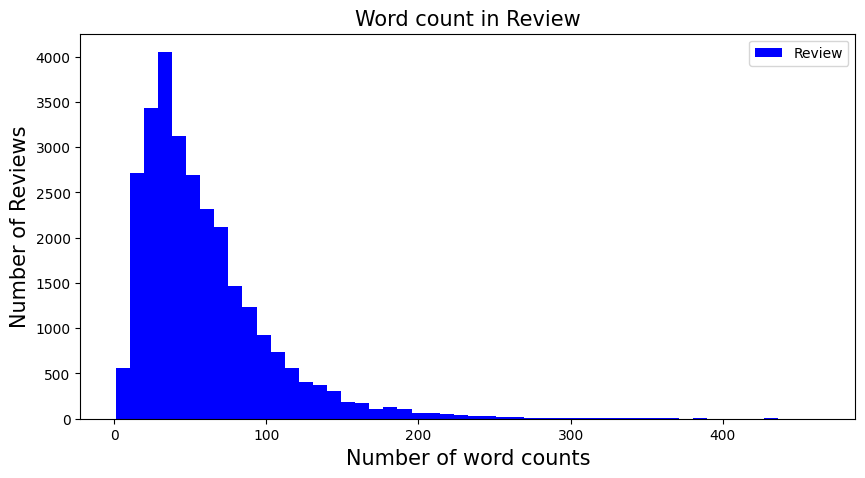

리뷰 단어 개수 최댓값 : 464
리뷰 단어 개수 최소값 : 1
리뷰 단어 개수 평균값 : 58.902514493011346
리뷰 단어 개수 상위 80%값 : 85.0


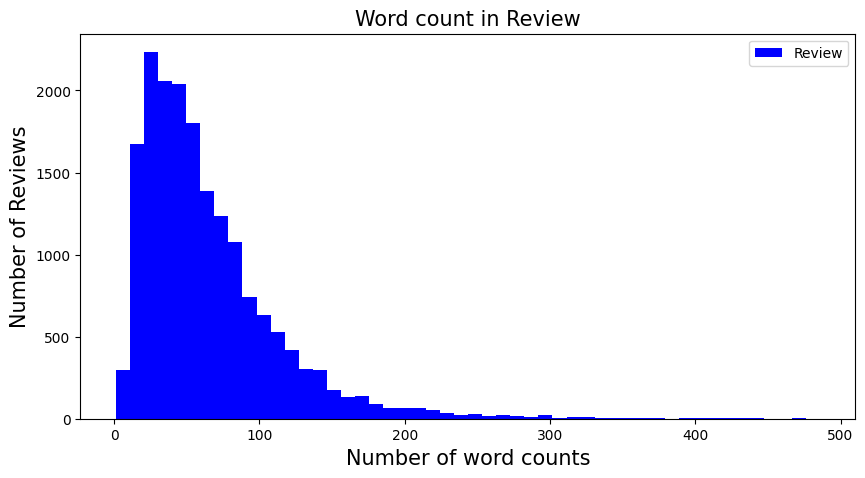

리뷰 단어 개수 최댓값 : 486
리뷰 단어 개수 최소값 : 1
리뷰 단어 개수 평균값 : 64.69100648435297
리뷰 단어 개수 상위 80%값 : 93.0


In [ ]:
def check_word_count(df=None):
  train_word_count = df['cleaned_text'].apply(lambda x: len(str(x).split(' ')))

  plt.figure(figsize=(10,5))
  plt.hist(train_word_count, bins=50, color='b', label='Review')
  plt.title('Word count in Review',fontsize=15)
  plt.legend()
  plt.xlabel('Number of word counts', fontsize=15)
  plt.ylabel('Number of Reviews', fontsize=15)
  plt.show()


  print(f'리뷰 단어 개수 최댓값 : {np.max(train_word_count)}')
  print(f'리뷰 단어 개수 최소값 : {np.min(train_word_count)}')
  print(f'리뷰 단어 개수 평균값 : {np.mean(train_word_count)}')
  print(f'리뷰 단어 개수 상위 80%값 : {np.percentile(train_word_count, 80)}')

check_word_count(cafe)
check_word_count(bar)

In [ ]:
cafe = cafe[['user_id', 'business_id', 'cleaned_text', 'stars_y']]
cafe_text = cafe.loc[cafe['cleaned_text'].str.len() > 1]
cafe_text.drop_duplicates(subset=['user_id', 'business_id'], inplace=True)
cafe_text.dropna(inplace=True)
cafe_text = cafe_text.loc[cafe_text['cleaned_text'] != 'nan']


bar = bar[['user_id', 'business_id', 'cleaned_text', 'stars_y']]
bar_text = bar.loc[bar['cleaned_text'].str.len() > 1]
bar_text.drop_duplicates(subset=['user_id', 'business_id'], inplace=True)
bar_text.dropna(inplace=True)
bar_text = bar_text.loc[bar_text['cleaned_text'] != 'nan']

<ipython-input-8-0fb43c3ca71b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cafe_text.drop_duplicates(subset=['user_id', 'business_id'], inplace=True)
<ipython-input-8-0fb43c3ca71b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cafe_text.dropna(inplace=True)
<ipython-input-8-0fb43c3ca71b>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bar_text.drop_duplicates(subset=['user_id', 'business_id'], inplace=True)
<ipython-input-8-0

In [ ]:
cafe_user_item_review = cafe_text.drop(['cleaned_text'], axis=1)
cafe_user_review = pd.pivot_table(cafe_text, index=['user_id', 'business_id'],
                             aggfunc=lambda x: x).drop('stars_y', axis=1)
cafe_bus_review = pd.pivot_table(cafe_text, index=['business_id', 'user_id'],
                            aggfunc=lambda x: x).drop('stars_y', axis=1)

bar_user_item_review = bar_text.drop(['cleaned_text'], axis=1)
bar_user_review = pd.pivot_table(bar_text, index=['user_id', 'business_id'],
                             aggfunc=lambda x: x).drop('stars_y', axis=1)
bar_bus_review = pd.pivot_table(bar_text, index=['business_id', 'user_id'],
                            aggfunc=lambda x: x).drop('stars_y', axis=1)

In [ ]:
def cafe_add_user_reviews(x):
  ur = cafe_user_review.loc[x['user_id']].drop(x['business_id']).values.tolist()
  br = cafe_bus_review.loc[x['business_id']].drop(x['user_id']).values.tolist()
  x['userReviews'] = ' '.join(list(map(lambda x: x[0], ur)))
  x['busReviews'] = ' '.join(list(map(lambda x: x[0], br)))
  return x

def bar_add_user_reviews(x):
  ur = bar_user_review.loc[x['user_id']].drop(x['business_id']).values.tolist()
  br = bar_bus_review.loc[x['business_id']].drop(x['user_id']).values.tolist()
  x['userReviews'] = ' '.join(list(map(lambda x: x[0], ur)))
  x['busReviews'] = ' '.join(list(map(lambda x: x[0], br)))
  return x


cafe_grouped_cleaned_data = cafe_user_item_review.apply(cafe_add_user_reviews, axis=1)
bar_grouped_cleaned_data = bar_user_item_review.apply(bar_add_user_reviews, axis=1)

In [ ]:
def init_embeddings_map(fname):
    '''
    glove embedding파일을 array형태로 푸는 함수
    '''
    with open(os.path.join("/content/drive/MyDrive/seminar/cdr_v2", fname)) as glove:
        return {l[0]: np.asarray(l[1:], dtype="float32") for l in
                [line.split() for line in glove]}


def get_embed_and_pad_func(i_seq_len, u_seq_len, pad_value, embedding_map):
    '''
    userReviews 및 busReviews에 glove embedding값을 부여하는 함수
    '''
    def embed(row):
        sentence = row["userReviews"].split()[:u_seq_len]
        reviews = list(map(lambda word: embedding_map.get(word)
            if word in embedding_map else pad_value, sentence))
        row["userReviews"] = reviews +\
                [pad_value] * (u_seq_len - len(reviews))
        sentence = row["busReviews"].split()[:i_seq_len]
        reviews = list(map(lambda word: embedding_map.get(word)
            if word in embedding_map else pad_value, sentence))
        row["busReviews"] = reviews +\
                [pad_value] * (i_seq_len - len(reviews))
        return row
    return embed

emb_size = 50
embedding_map = init_embeddings_map('glove.6B.'+str(emb_size) + "d.txt")

In [ ]:
def normalize(x):
  '''
  MLP / GMF / NCF - sigmoid 용 정규화 모델
  Min-Max Scaler 사용
  '''
  normalized_x = (((x-1) / (5-1)))
  return normalized_x

def de_normalize(x):
  '''
  normalize된 평점이 다시 원래 값을 갖도록 설정
  '''
  original_x = 4 * ((x - 0) / (1 - 0)) + 1
  return original_x

In [ ]:
# making dataset - Cafe
test_size = 0.2

cafe_users = cafe_grouped_cleaned_data['user_id'].unique()
cafe_users_size = len(cafe_users)
cafe_test_users = np.random.choice(cafe_users, int(cafe_users_size * test_size), replace=False)

cafe_train_users = set(cafe_users) - set(cafe_test_users)

cafe_train = cafe_grouped_cleaned_data[cafe_grouped_cleaned_data['user_id'].isin(cafe_train_users)]
cafe_test = cafe_grouped_cleaned_data[cafe_grouped_cleaned_data['user_id'].isin(cafe_test_users)]

cafe_unique_test_bus = cafe_test['business_id'].unique()
cafe_train = cafe_train.loc[~(cafe_train['business_id'].isin(cafe_unique_test_bus))]

cafe_user_seq_sizes = cafe_grouped_cleaned_data['userReviews'].apply(lambda x: x.split()).apply(len)
cafe_bus_seq_sizes = cafe_grouped_cleaned_data['busReviews'].apply(lambda x: x.split()).apply(len)

u_ptile = 40
i_ptile = 15
cafe_u_seq_len = int(np.percentile(cafe_user_seq_sizes, u_ptile))
cafe_i_seq_len = int(np.percentile(cafe_bus_seq_sizes, i_ptile))

embedding_fn = get_embed_and_pad_func(cafe_i_seq_len, cafe_u_seq_len, np.array([0.0] * emb_size), embedding_map)
cafe_train_embedded = cafe_train.apply(embedding_fn, axis=1)
cafe_train_embedded['stars_y_scaled'] = cafe_train_embedded['stars_y'].apply(lambda x: normalize(x))
cafe_test_embedded = cafe_test.apply(embedding_fn, axis=1)

In [ ]:
# making dataset - Bar
test_size = 0.2

bar_users = bar_grouped_cleaned_data['user_id'].unique()
bar_users_size = len(bar_users)
bar_test_users = np.random.choice(bar_users, int(bar_users_size * test_size), replace=False)

bar_train_users = set(bar_users) - set(bar_test_users)

bar_train = bar_grouped_cleaned_data[bar_grouped_cleaned_data['user_id'].isin(bar_train_users)]
bar_test = bar_grouped_cleaned_data[bar_grouped_cleaned_data['user_id'].isin(bar_test_users)]

bar_unique_test_bus = bar_test['business_id'].unique()
bar_train = bar_train.loc[~(bar_train['business_id'].isin(bar_unique_test_bus))]

bar_user_seq_sizes = bar_grouped_cleaned_data['userReviews'].apply(lambda x: x.split()).apply(len)
bar_bus_seq_sizes = bar_grouped_cleaned_data['busReviews'].apply(lambda x: x.split()).apply(len)

u_ptile = 40
i_ptile = 15
bar_u_seq_len = int(np.percentile(bar_user_seq_sizes, u_ptile))
bar_i_seq_len = int(np.percentile(bar_bus_seq_sizes, i_ptile))

embedding_fn = get_embed_and_pad_func(bar_i_seq_len, bar_u_seq_len, np.array([0.0] * emb_size), embedding_map)
bar_train_embedded = bar_train.apply(embedding_fn, axis=1)
bar_train_embedded['stars_y_scaled'] = bar_train_embedded['stars_y'].apply(lambda x: normalize(x))
bar_test_embedded = bar_test.apply(embedding_fn, axis=1)

In [ ]:
# DeepCoNN

class DeepCoNN():
    def __init__(self, embedding_size, hidden_size, u_seq_len, i_seq_len, filters=100, kernel_size=3, strides=1):

        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.filters = filters
        self.kernel_size = kernel_size
        self.inputU, self.towerU = self.create_deepconn_tower(u_seq_len)
        self.inputM, self.towerM = self.create_deepconn_tower(i_seq_len)
        self.joined = Concatenate()([self.towerU, self.towerM])
        self.outNeuron = Dense(1)(self.joined)

    def create_deepconn_tower(self, max_seq_len):
        input_layer = Input(shape=(max_seq_len, self.embedding_size))
        tower = Conv1D(filters=self.filters,
                       kernel_size=(self.kernel_size),
                       activation="tanh")(input_layer)
        tower = MaxPooling1D()(tower)
        tower = Flatten()(tower)
        tower = Dense(self.hidden_size, activation="relu")(tower)
        return input_layer, tower

    def create_deepconn_dp(self):
        dotproduct = Dot(axes=1)([self.towerU, self.towerM])
        output_1 = Add()([self.outNeuron, dotproduct])
        output = Dense(1, activation='sigmoid')(output_1)  # 0~1사이 값이 결과로 나오게끔 마지막 출력층 구조 변형
        self.model = Model(inputs=[self.inputU, self.inputM], outputs=[output])
        self.model.compile(optimizer='Adam', loss='binary_crossentropy')

    def train(self, train_data, batch_size, epochs):
        self.create_deepconn_dp()
        user_reviews = np.array(list(train_data.loc[:, "userReviews"]))
        bus_reviews = np.array(list(train_data.loc[:, "busReviews"]))
        aa = [user_reviews, bus_reviews]
        self.train_inputs = aa
        self.train_outputs = train_data.loc[:, "stars_y_scaled"]
        print(self.train_outputs.shape)
        self.history = self.model.fit(self.train_inputs,
                                      self.train_outputs,
                                      callbacks=[es, rp],
                                      validation_split=0.2,
                                      batch_size=batch_size,
                                      epochs=epochs)

        return self.history, self.model

es = EarlyStopping(monitor='val_loss', mode='min', patience=5, min_delta=0.001, restore_best_weights=True)
rp = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=2, min_delta=0.001)

In [ ]:
hidden_size = 64
cafe_deepconn = DeepCoNN(emb_size, hidden_size, cafe_u_seq_len, cafe_i_seq_len)
cafe_deepconn.train(cafe_train_embedded, batch_size=32, epochs=100)

(2244,)
Epoch 1/100
57/57 [==============================] - 3s 11ms/step - loss: 0.9314 - val_loss: 0.6908 - lr: 0.0010
Epoch 2/100
57/57 [==============================] - 0s 7ms/step - loss: 0.6118 - val_loss: 0.6069 - lr: 0.0010
Epoch 3/100
57/57 [==============================] - 0s 8ms/step - loss: 0.5537 - val_loss: 0.6100 - lr: 0.0010
Epoch 4/100
57/57 [==============================] - 0s 7ms/step - loss: 0.5179 - val_loss: 0.6151 - lr: 0.0010
Epoch 5/100
57/57 [==============================] - 0s 7ms/step - loss: 0.4801 - val_loss: 0.6242 - lr: 1.0000e-04
Epoch 6/100
57/57 [==============================] - 0s 8ms/step - loss: 0.4730 - val_loss: 0.6234 - lr: 1.0000e-04
Epoch 7/100
57/57 [==============================] - 1s 11ms/step - loss: 0.4673 - val_loss: 0.6239 - lr: 1.0000e-05


(<keras.callbacks.History at 0x7fdeb6ec2a70>,
 <keras.engine.functional.Functional at 0x7fde770d62c0>)

In [ ]:
cafe_user_reviews = np.array(list(cafe_test_embedded["userReviews"]))
cafe_bus_reviews = np.array(list(cafe_test_embedded["busReviews"]))

cafe_test_inputs = [cafe_user_reviews, cafe_bus_reviews]

true_rating = np.array(list(cafe_test_embedded["stars_y"])).reshape((-1, 1))

predictions = cafe_deepconn.model.predict(cafe_test_inputs)
predictions = 4 * ((predictions - predictions.min()) / (predictions.max() - predictions.min())) + 1
rmse_temp = mean_squared_error(cafe_test['stars_y'], predictions, squared=False)
mae_temp = mean_absolute_error(cafe_test['stars_y'], predictions)
print(f'rmse : {rmse_temp}')
print(f'mae : {mae_temp}')

167/167 [==============================] - 0s 2ms/step
rmse : 1.04224166639571
mae : 0.8399795265829836


In [ ]:
bar_deepconn = DeepCoNN(emb_size, hidden_size, bar_u_seq_len, bar_i_seq_len)
bar_deepconn.train(bar_train_embedded, batch_size=32, epochs=100)

(611,)
Epoch 1/100
16/16 [==============================] - 3s 25ms/step - loss: 2.3559 - val_loss: 0.7545 - lr: 0.0010
Epoch 2/100
16/16 [==============================] - 0s 11ms/step - loss: 0.6657 - val_loss: 0.6087 - lr: 0.0010
Epoch 3/100
16/16 [==============================] - 0s 12ms/step - loss: 0.5872 - val_loss: 0.6047 - lr: 0.0010
Epoch 4/100
16/16 [==============================] - 0s 11ms/step - loss: 0.5512 - val_loss: 0.5888 - lr: 0.0010
Epoch 5/100
16/16 [==============================] - 0s 10ms/step - loss: 0.5174 - val_loss: 0.5881 - lr: 0.0010
Epoch 6/100
16/16 [==============================] - 0s 11ms/step - loss: 0.4901 - val_loss: 0.5811 - lr: 0.0010
Epoch 7/100
16/16 [==============================] - 0s 10ms/step - loss: 0.4618 - val_loss: 0.5869 - lr: 0.0010
Epoch 8/100
16/16 [==============================] - 0s 10ms/step - loss: 0.4469 - val_loss: 0.5940 - lr: 0.0010
Epoch 9/100
16/16 [==============================] - 0s 10ms/step - loss: 0.4313 - val_lo

(<keras.callbacks.History at 0x7fb497399e40>,
 <keras.engine.functional.Functional at 0x7fb4a0007ac0>)

In [ ]:
bar_user_reviews = np.array(list(bar_test_embedded["userReviews"]))
bar_bus_reviews = np.array(list(bar_test_embedded["busReviews"]))

bar_test_inputs = [bar_user_reviews, bar_bus_reviews]

true_rating = np.array(list(bar_test_embedded["stars_y"])).reshape((-1, 1))

predictions = bar_deepconn.model.predict(bar_test_inputs)
predictions = 4 * ((predictions - predictions.min()) / (predictions.max() - predictions.min())) + 1
rmse_temp = mean_squared_error(bar_test['stars_y'], predictions, squared=False)
mae_temp = mean_absolute_error(bar_test['stars_y'], predictions)
print(f'rmse : {rmse_temp}')
print(f'mae : {mae_temp}')

108/108 [==============================] - 0s 3ms/step
rmse : 1.1140229787702327
mae : 0.8958015930462849
